# TWITTER ANALYSIS - MENTORSHIP PROJECT


#### STEP 1. CONFIGURATION: ESTABLISHING CONNECTION TO THE API
*Using Tweepy*

In [1]:
import tweepy 
import configparser
import requests     # For saving access tokens and for file management when creating and adding to the dataset
import os           # For dealing with json responses we receive from the API
import json         # For displaying the data after
import pandas as pd # For saving the response data in CSV format
import csv          # For parsing the dates received from twitter in readable formats
import datetime
import dateutil.parser
import unicodedata  #To add wait time between requests
import time

In [2]:
#read configs
config = configparser.ConfigParser()
config.read('config.ini')

api_key             = config['twitter']['api_key']
api_key_secret      = config['twitter']['api_key_secret']

access_token        = config['twitter']['access_token']
access_token_secret = config['twitter']['access_token_secret']

bearer_token        = config['twitter']['bearer_token']

In [3]:
#Authenticate our account with the Twitter API
auth    = tweepy.OAuthHandler(api_key, api_key_secret)
auth.set_access_token(access_token, access_token_secret)
api     = tweepy.API(auth, wait_on_rate_limit=True)

# You can authenticate as your app with just your bearer token
client  = tweepy.Client(bearer_token=bearer_token)

# If the authentication was successful, this should print the
# screen name / username of the account
print(api.verify_credentials().screen_name)

KLuthra_


### STEP 2. DATA EXTRACTION & CLEANING
####  2.1. Defining a tweet fetching function using Tweepy

**__Pagination:__** Pagination is a feature in Twitter API v2 endpoints that return more results than can be returned in a single response. When that happens, the data is returned in a series of 'pages'. Pagination refers to methods for programatically requesting all of the pages, in order to retrieve the entire result data set. Not all API endpoints support or require pagination, but it is often used when result sets are large.

**Paginator** can be used to paginate for any Client methods that support pagination

In [4]:
def get_tweets(query, max_results):

  expansions    = ['author_id','in_reply_to_user_id','geo.place_id','entities.mentions.username','referenced_tweets.id','referenced_tweets.id.author_id']
  tweet_fields  = ['id','text','author_id','attachments','context_annotations','created_at','entities','lang','geo','public_metrics']
  user_fields   = ['id','name','username','created_at','description','entities','location','public_metrics','verified']
  place_fields  = ['full_name','id','country','country_code','geo','name','place_type']
  try:
    # call twitter api to fetch tweets
    fetched_tweets = tweepy.Paginator(client.search_recent_tweets, query=query,
      expansions        =expansions,
      tweet_fields      =tweet_fields,
      place_fields      =place_fields,
      user_fields       =user_fields,
      max_results       =max_results
    ).flatten()
    
    return fetched_tweets
    

  except Exception as e:
    print("Error getting tweets", e)

####  2.2. Extracting Domains and Entities from the Twitter API
*Annotations have been added to the Tweet object from all v2 endpoints that return a Tweet object. Tweet annotations offer a way to understand contextual information about the Tweet itself. Though 100% of Tweets are reviewed, due to the contents of Tweet text, only a portion are annotated.*

##### **Tweet annotation types**
**Entities** Entity annotations are programmatically defined entities that are nested within the entities field and are reflected as annotations in the payload. Each annotation has a confidence score and an indication of where in the Tweet text the entities were identified (start and end fields).

The entity annotations can have the following types:

1. Person - Barack Obama, Daniel, or George W. Bush
2. Place - Detroit, Cali, or "San Francisco, California"
3. Product - Mountain Dew, Mozilla Firefox
4. Organization - Chicago White Sox, IBM
5. Other - Diabetes, Super Bowl 50

**Context annotations** are delivered as a context_annotations field in the payload. These annotations are inferred based on semantic analysis (keywords, hashtags, handles, etc) of the Tweet text and result in domain and/or entity labels. Context annotations can yield one or many domains. At present, we’re using a list of 80+ domains reflected in the table below.  
1. ID - 45: Brand Vertical
2. ID - 46: Brand Category
3. ID - 47: Brand
4. ID - 48: Product

##### 2.2.1 DOMAIN-ENTITY QUERY CONSTRUCTION 
The *search_recent_tweets* function within the Twitter API has a query limit of 512 characters. To work around this, I have created a list of strings, less than 512 characters long, which contain the domain_id.entity_id search query broken up into chunks of 512 characters or less each which I will iterate through when making API requests to retrieve tweets

In [5]:
domain_df = pd.read_csv('twitter-context-annotations/files/evergreen-context-entities-20220601.csv')
import itertools
def automate_domain_filter(df, start_id, end_id, chunk_size, domain_chunk_count):
    chunks_list = []
    for i in range(start_id, end_id+1):
        context_list = []
        mask = df['domains'].str.contains('^{}$'.format(i))
        filtered_df = df[mask]
        for index, row in filtered_df.iterrows():
            domain_id = row['domains']
            entity_id = row['entity_id']
            entity_name = row['entity_name']   
            # construct the query string
            context = f'context:{domain_id}.{entity_id}'
            context_list.append(context)
            context_query = ' OR '.join(context_list)
        code = context_query
        chunks = []
        start = 0
        counter = 0
        while start < len(code) and counter < domain_chunk_count[i]:
            end = start + chunk_size
            if end >= len(code):
                end = len(code)
            end = code.rfind(" OR ", start, end)
            if end == -1:
                end = start + chunk_size
            chunk = code[start:end]
            if chunk.startswith(" OR "):
                chunk = chunk[4:]
            chunks.append(chunk)
            start = end
            counter += 1
        chunks_list.append(chunks)
    return list(itertools.chain.from_iterable(chunks_list))

chunk_size = 350
domain_chunk_count = {45: 1, 46: 6, 47: 276, 48: 69}
chunks_list = automate_domain_filter(domain_df, 45, 48, chunk_size, domain_chunk_count)
# print(chunks_list)

In [49]:
domain_df = pd.read_csv('twitter-context-annotations/files/evergreen-context-entities-20220601.csv')


##### 2.2.2 Defining Pre-Extraction Filtering 
- [ X ] Language restricted to English 
- [ X ] No Retweets or Quote Retweets Allowed
- [ X ] Filtering for tweets within Domains 45 through 48 (*all entities*)
- [ X ] Tweets must have mentions (*indicates presence of brand/sponsor*)
- [ X ] Hashtag List consisting of indications that the tweet is being promoted or sponsored
- [ ] Possible Entity Names which are irrelevant

##### 2.2.3 Defining Post-Extraction Filtering 
  1. Accounts that have a high ratio of followers to following (e.g., following fewer than 100 accounts but having thousands of followers)
  2. Number of Followers
  1. Accounts that use a large number of hashtags in their tweets (e.g., more than 5 hashtags per tweet).
  2. Accounts that use a lot of capital letters or exclamation points in their tweets.
  3. Accounts that have a high percentage of tweets that contain links (e.g., more than 50% of tweets contain links).   
  5. Using the Botometer API to extract a score for each user that indicates the probabibily of the account being a bot. 

In [6]:
def filter_rule(chunk, hash_include=True):
    text_list       = '(#ad OR #sponsored OR #promoted OR "Learn More" OR "Shop Now")'
    lang            = '(lang:en)'
    rt              = '(-is:retweet) (-"RT")' 
    domain            = chunk
    mention         = 'has:mentions'
    if hash_include == True:
        query           = text_list + ' ' + lang + ' ' + rt + ' ' +  mention + ' ' + '(' + domain + ')'
    else: 
        query           = text_list + ' ' + lang + ' ' + rt + ' ' +  mention

    return query

In [6]:
csvFile     = open("tweets.csv", "a", newline="", encoding='utf-8')
csvWriter   = csv.writer(csvFile)

#Create headers for the data you want to save, in this example, we only want save these columns in our dataset
csvWriter.writerow(['author_id', 'tweet_id', 'text', 'created_at','tweet_metrics', 'context', 'entities', 'place_id'])
csvFile.close()

In [7]:
def append_to_csv_tweets(data, fileName):
# Create a dictionary with field names as keys
    row = {"author_id":     data['author_id'],
           "tweet_id":      data['tweet_id'],
           "text":          data['text'],
           "created_at":    data['created_at'],
           "tweet_metrics": data['tweet_metrics'],
           "context":       data['context'],
           "entities":      data['entities'],
           "place_id":      data['place_id']}
    
    # Append the result to the CSV file
    # Open the CSV file and write the row
    csvFile     = open(fileName, "a", newline="", encoding='utf-8')
    csvWriter   = csv.DictWriter(csvFile, fieldnames=row.keys())
    
    csvWriter.writerow(row)
    csvFile.close()

In [ ]:
        # "place_id": data['place_id'],
        #    "country_code": data['country_code'],
        #    "country": data['country'],
        #    "full_place_name": data['full_place_name'],
        #    "short_place_name": data['short_place_name'],  
        #    "place_type": data['place_type']}
   

In [8]:
def deduplicate(file_path):
    df = pd.read_csv(file_path)
    df = df.drop_duplicates(subset=['tweet_id'])
    df = df.sort_values(by='created_at',ascending=False)
    df.to_csv(file_path, index=False)

In [ ]:
for chunk in chunks_list:
        print(f'Chunk: {chunk}')
        # read CSV file
        results = pd.read_csv('tweets.csv')
        # count no. of lines
        print(f'Number of lines pre-extraction: {len(results)}')
        
        query       = filter_rule(chunk=chunk)
        paginator   = get_tweets(query=query, max_results=100)
        for tweet in paginator:
        # Assemble all data in a list
                data = {"author_id":    tweet.author_id,
                        "tweet_id":     tweet.id,
                        "text":         tweet.text,
                        "created_at":   tweet.created_at,
                        "tweet_metrics":tweet.public_metrics,
                        "context":      tweet.context_annotations,
                        "entities":     tweet.entities,
                        "place_id":     tweet.geo
                        }
                append_to_csv_tweets(data, fileName="tweets.csv")
        time.sleep(16)

        results = pd.read_csv('tweets.csv')
        print(f'Number of lines post-extraction: {len(results)}')
 
deduplicate("tweets.csv")

In [9]:
# Load dev_tweets.csv file into a Pandas dataframe
dev_tweets = pd.read_csv('tweets.csv')

# Extract the author IDs from dev_tweets
author_ids = [x for x in set(dev_tweets["author_id"].tolist()) if x != 'author_id']

user_data = []
batch_size = 100
n = 0
for i in range(0, len(author_ids), batch_size):
        
        # try:
        users = client.get_users(ids=author_ids[i:i+batch_size], ##initially using api.lookup_users
        user_fields=['id','name','username','created_at','description','entities','location','public_metrics','verified'])  
          
        for user in users.data:
                user_dict = {
                "author_id":    user.id,
                "username":     user.username,
                "verified":     user.verified,
                "bio":          user.description,
                "author_created":   user.created_at,
                "author_location":  user.location, 
                "author_metrics":   user.public_metrics,
                "followers_count":  user.public_metrics['followers_count'],
                "following_count":  user.public_metrics['following_count'],
                "tweet_count":      user.public_metrics['tweet_count'],
                "author_entites":   user.entities
                }
                n=n+1
                user_data.append(user_dict)
        time.sleep(16)        
        # except Exception as e:
        #         print(f"An error occurred: {e}")

In [22]:
# Convert the list of dictionaries to a dataframe
import numpy as np
user_data_df = pd.DataFrame(user_data)
dev_tweets = dev_tweets[dev_tweets['author_id'] != 'author_id']
dev_tweets["author_id"] = dev_tweets["author_id"].astype(np.int64)
user_data_df["author_id"] = user_data_df["author_id"].astype(np.int64)

print(dev_tweets["author_id"].dtypes)
print(user_data_df["author_id"].dtypes)


int64
int64


In [23]:
dev_tweets_temp = pd.merge(dev_tweets, user_data_df, on='author_id', how='left')

In [33]:
dev_tweets_temp.head()

,author_id,tweet_id,text,created_at,tweet_metrics,context,entities,place_id,username,verified,bio,author_created,author_location,author_metrics,followers_count,following_count,tweet_count,author_entites
0,792182745942233089,1627522226336546816,#SneakerScouts The New Balance Women's 550 'Se...,2023-02-20 04:15:11+00:00,"{'retweet_count': 0, 'reply_count': 0, 'like_c...","[{'domain': {'id': '30', 'name': 'Entities [En...","{'urls': [{'start': 136, 'end': 159, 'url': 'h...",NaN,SneakerScouts,False,"The #1 source for sneaker news, release dates,...",2016-10-29 01:54:19+00:00,Worldwide,"{'followers_count': 20945, 'following_count': ...",20945.0,8433.0,394747.0,"{'url': {'urls': [{'start': 0, 'end': 23, 'url..."
1,792182745942233089,1627515927867670528,#SneakerScouts The Nike Women's Air Max 97 'He...,2023-02-20 03:50:09+00:00,"{'retweet_count': 1, 'reply_count': 0, 'like_c...","[{'domain': {'id': '30', 'name': 'Entities [En...","{'mentions': [{'start': 71, 'end': 82, 'userna...",NaN,SneakerScouts,False,"The #1 source for sneaker news, release dates,...",2016-10-29 01:54:19+00:00,Worldwide,"{'followers_count': 20945, 'following_count': ...",20945.0,8433.0,394747.0,"{'url': {'urls': [{'start': 0, 'end': 23, 'url..."
2,792182745942233089,1627515927595044864,#SneakerScouts The Nike Women's Air Max 97 'He...,2023-02-20 03:50:09+00:00,"{'retweet_count': 1, 'reply_count': 0, 'like_c...","[{'domain': {'id': '30', 'name': 'Entities [En...","{'mentions': [{'start': 71, 'end': 82, 'userna...",NaN,SneakerScouts,False,"The #1 source for sneaker news, release dates,...",2016-10-29 01:54:19+00:00,Worldwide,"{'followers_count': 20945, 'following_count': ...",20945.0,8433.0,394747.0,"{'url': {'urls': [{'start': 0, 'end': 23, 'url..."
3,4128627314,1627513902841098241,"@JazzNationCP Wow, a 10-time All-Star in Stock...",2023-02-20 03:42:06+00:00,"{'retweet_count': 0, 'reply_count': 0, 'like_c...","[{'domain': {'id': '3', 'name': 'TV Shows', 'd...","{'annotations': [{'start': 41, 'end': 48, 'pro...",NaN,lapattyball,False,,2015-11-04 22:49:16+00:00,"Bend, OR","{'followers_count': 165, 'following_count': 44...",165.0,444.0,1516.0,None
4,132077186,1627513577702821890,@terriwpg @Bo_44 The best harness I’ve ever fo...,2023-02-20 03:40:49+00:00,"{'retweet_count': 0, 'reply_count': 1, 'like_c...","[{'domain': {'id': '45', 'name': 'Brand Vertic...","{'urls': [{'start': 256, 'end': 279, 'url': 'h...",NaN,RiderGirl4Life,False,"Dog lover, Mental health advocate, Ally, Survi...",2010-04-12 06:21:51+00:00,None,"{'followers_count': 711, 'following_count': 69...",711.0,692.0,20874.0,None


In [29]:
print(dev_tweets_temp.shape)
print(dev_tweets_temp.info())

(70291, 18)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 70291 entries, 0 to 70290
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   author_id        70291 non-null  int64              
 1   tweet_id         70291 non-null  object             
 2   text             70291 non-null  object             
 3   created_at       70291 non-null  object             
 4   tweet_metrics    70291 non-null  object             
 5   context          70291 non-null  object             
 6   entities         70289 non-null  object             
 7   place_id         195 non-null    object             
 8   username         56326 non-null  object             
 9   verified         56326 non-null  object             
 10  bio              56326 non-null  object             
 11  author_created   56326 non-null  datetime64[ns, UTC]
 12  author_location  21473 non-null  object             
 13  auth

In [ ]:
dev_tweets_temp['verified'] = dev_tweets_temp['verified'].astype(bool)

In [34]:
import json
import ast

def extract_dict_values(df, column_name):
    df[column_name] = df[column_name].apply(lambda x: ast.literal_eval(x))
    df = pd.concat([df.drop([column_name], axis=1), df[column_name].apply(pd.Series)], axis=1)
    return df

df = extract_dict_values(dev_tweets_temp, "context")
df = extract_dict_values(dev_tweets_temp, "entities")
df = extract_dict_values(dev_tweets_temp, "author_metrics")
df = extract_dict_values(dev_tweets_temp, "author_entities")

ValueError: malformed node or string: nan

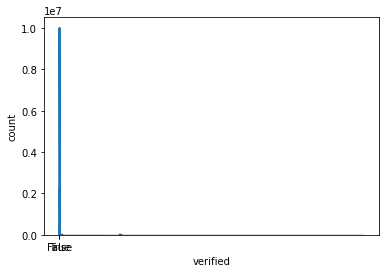

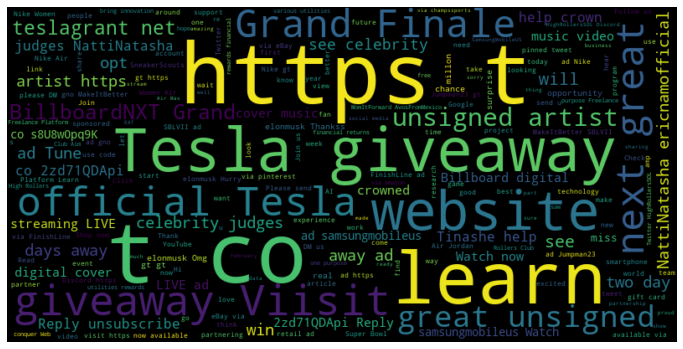

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt


# Distribution of tweet counts
sns.histplot(dev_tweets_temp['tweet_count'])

# Distribution of followers counts
sns.histplot(dev_tweets_temp['followers_count'])

# Distribution of following counts
sns.histplot(dev_tweets_temp['following_count'])

# Distribution of verified accounts
sns.countplot(x='verified', data=dev_tweets_temp)

# Distribution of tweets over time
sns.lineplot(x='created_at', y='tweet_count', data=dev_tweets_temp)

# Word cloud of the most common words in the text column
from wordcloud import WordCloud
text = ' '.join(dev_tweets_temp['text'].tolist())
wordcloud = WordCloud(width=800, height=400, max_font_size=100).generate(text)
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [ ]:
# head(): displays the first n rows of the dataframe, where n is an optional argument (default is 5).

# tail(): displays the last n rows of the dataframe, where n is an optional argument (default is 5).

# describe(): generates descriptive statistics of all the columns in the dataframe, including mean, standard deviation, minimum, maximum, and quartiles.

# shape: returns the number of rows and columns in the dataframe.

# info(): displays information about the dataframe, including the data type of each column, the number of non-null values, and memory usage.

# value_counts(): returns a count of unique values in a particular column.

# correlation(): returns a correlation matrix for all the columns in the dataframe.

# groupby(): groups the dataframe by one or more columns and returns a summary of the groups.

# pivot_table(): generates a pivot table from the dataframe.

In [ ]:
df = pd.read_csv("data.csv")
df.to_json(r'data.json',orient='records')

In [26]:
# # Create a dataframe from the user_data list
# df = pd.DataFrame(user_data)

# # Extract the author_id column from the dataframe
# author_id_column = df['author_id']

# # Get the number of unique author IDs
# unique_author_ids = author_id_column.nunique()

# # Print the result
# print("Number of unique author IDs: ", unique_author_ids)


# unique_author_ids = set(author_ids)
# number_of_unique_author_ids = len(unique_author_ids)

# print("Number of unique author IDs 2: ", number_of_unique_author_ids)


Number of unique author IDs:  5949
Number of unique author IDs 2:  5970


### TEST CODE 
-------------------------

In [ ]:
for chunk in chunks:
    query       = filter_rule(chunk=chunk)
    paginator   = get_tweets(query=query, max_results=100)
    for tweet in paginator:
    # Assemble all data in a list
        print(f"author_id :     {tweet.author_id}")
        print(f"created_at:     {tweet.created_at}")
        print(f"tweet_id:       {tweet.id}")
        print(f"text:           {tweet.text}")
        print(f"geo:            {tweet.geo}")
        print(f"tweet_metrics:  {tweet.public_metrics}")
        print(f"context:        {tweet.context_annotations}")
        print(f"entites:        {tweet.entities}")
        print(f"promo:          {tweet.promoted_metrics}")
        print(f"source:         {tweet.source}")

#     append_to_csv(data, fileName="test.csv")
 # Save data as dictionary
#     tweets_dict = tweets.json() 
    
#     tweets_data     = tweets_dict["data"]
#     # tweets_includes = tweets_dict["includes"]
#     tweets_NT       = tweets_dict["meta"]["next_token"]
    
# users = tweets_includes["users"]
# users = {user["id"]: user for user in users}

# for tweet in tweets_data:
#     author_id = int(tweet["author_id"])
#     print(f'USER ID:                    {users[tweet["author_id"]]["id"]}')
#     print(f'USER NAME:                  {users[tweet["author_id"]]["name"]}')
#     print(f'HANDLE:                     {users[tweet["author_id"]]["username"]}')
#     print(f'VERIFIED:                   {users[tweet["author_id"]]["verified"]}')
#     print(f'BIO:                        {users[tweet["author_id"]]["description"]}')
#     print(f'METRICS:                    {users[tweet["author_id"]]["public_metrics"]}')
#     print(f"TWEET ID:                   {tweet['id']}") 
#     print(f"TEXT:                       {tweet['text']}")
#     print(f"CREATED AT:                 {tweet['created_at']}")
#     print(f"TWEET METRICS:              {tweet['public_metrics']}")
#     context_annotations = tweet.get("context_annotations",[])
#     print(f"CONTEXT - DOMAIN:           {list(map(itemgetter('domain'), context_annotations))}")
#     print(f"CONTEXT - ENTITY:           {list(map(itemgetter('entity'), context_annotations))}")
#     entities = tweet.get("entities",[])
#     print(f"ENTITIES:                   {entities}\n")


#### ARCHIVE CODE - MANUAL PAGINATION METHOD BEING SCRAPED
---------------------------------------------------------------------------

In [ ]:
#input
import csv
count           = 0
max_results     = 100 #per Page
# flag            = True
# next_token      = None

for chunk in chunks:
    flag        = True
    next_token  = None
    print(f'Chunk: {chunk}')
    query       = filter_rule(chunk=chunk)
    while flag:
       
        print("--------------------")
        print("Token: ", next_token)
        tweets  = get_tweets(query=query,next_token=next_token,max_results=max_results)
        tweets_dict = tweets.json() 
        result_count = tweets_dict['meta']['result_count'] 

        if 'next_token' in tweets_dict['meta']:
            next_token = tweets_dict['meta']['next_token']
            print("Next Token: ", next_token)

            if result_count is not None and result_count > 0 and next_token is not None:
                append_to_csv(tweets_dict, "test.csv")
                count += result_count
                total_tweets += result_count
                print("Total # of Tweets added: ", total_tweets)
                print("--------------------------")
                time.sleep(5)

            # If no next token exists
        else:
            if result_count is not None and result_count > 0:
                print("-------------------")
                append_to_csv(tweets_dict, "test.csv")
                count += result_count
                total_tweets += result_count
                print("Total # of Tweets added: ", total_tweets)
                print("-------------------")
                time.sleep(5)
                    
                #Since this is the final request, turn flag to false to move to the next time period.
                flag = False
                next_token = None
        time.sleep(5)

# df = pd.read_csv("data.csv")       
print("Total number of results: ", total_tweets)
deduplicate("test.csv")

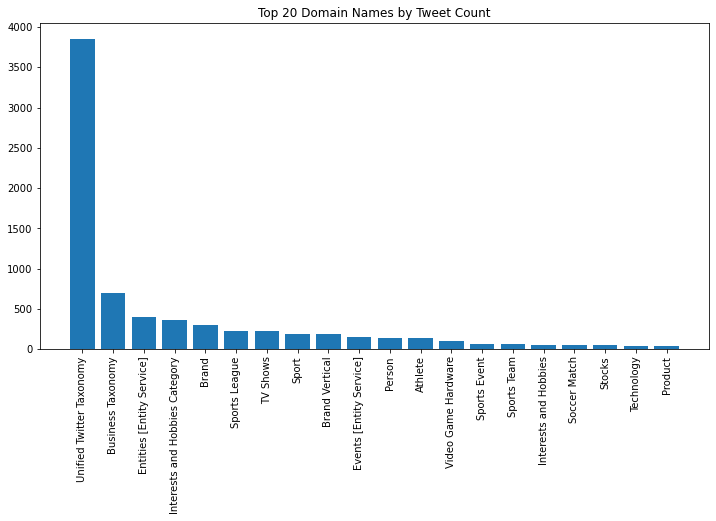

In [124]:
import matplotlib.pyplot as plt

# Extract the domain names from the Domain_Name field
domain_names = [name for row in df['Domain_Name'] for name in row]

# Use the Counter function from the collections module to count the number of tweets for each domain
from collections import Counter
domain_counts = Counter(domain_names)

# Sort the domain names by count in descending order
sorted_domain_counts = sorted(domain_counts.items(), key=lambda item: item[1], reverse=True)

# Get the top 20 domain names and tweet counts
top_20_domains = sorted_domain_counts[:20]
domains = [domain for domain, count in top_20_domains]
tweet_counts = [count for domain, count in top_20_domains]

# Create a figure with a larger size
fig = plt.figure(figsize=(12, 6))

# Create a bar plot of the tweet count for each domain
plt.bar(domains, tweet_counts)

# Add a title to the plot
plt.title('Top 20 Domain Names by Tweet Count')

# Rotate the tick labels to make them easier to read
plt.xticks(rotation=90)

plt.show()

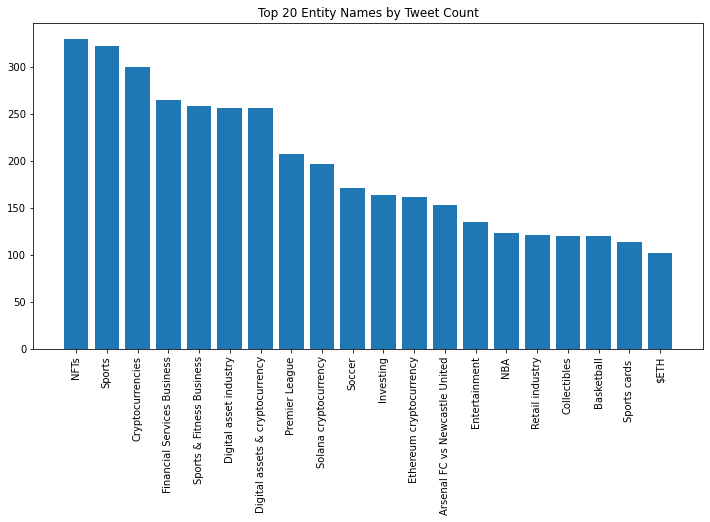

In [125]:
import matplotlib.pyplot as plt

# Extract the entity names from the Entity_Name field
entity_names = [name for row in db['Entity_Name'] for name in row]

# Use the Counter function from the collections module to count the number of tweets for each entity
from collections import Counter
entity_counts = Counter(entity_names)

# Sort the entity names by count in descending order
sorted_entity_counts = sorted(entity_counts.items(), key=lambda item: item[1], reverse=True)

# Get the top 20 entity names and tweet counts
top_20_entities = sorted_entity_counts[:20]
entities = [entity for entity, count in top_20_entities]
tweet_counts = [count for entity, count in top_20_entities]

# Create a figure with a larger size
fig = plt.figure(figsize=(12, 6))

# Create a bar plot of the tweet count for each entity
plt.bar(entities, tweet_counts)

# Add a title to the plot
plt.title('Top 20 Entity Names by Tweet Count')

# Rotate the tick labels to make them easier to read
plt.xticks(rotation=90)

plt.show()

---------------------------------------------------------------------------
